In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import numpy as np
import re
import preprocessor as p
import emoji
import regex

sns.set_style("whitegrid", {'axes.grid' : False})

pd.set_option('display.max_columns', None)

In [216]:
df = pd.read_csv('df_tweets.csv', index_col=0)

### Sanity check and cleaning
Observe the entire data and check for data types and values
#### Overall of the dataset

In [217]:
df.head(2)

,author,tweet_id,text,favorite_count,rewteet_count,created_at,source,reply_to_status,reply_to_user,retweets,favorites,account_location,followers,total_tweets,account_create
0,JoeBiden,1202037302265925634,I applaud Monday's sentences against seven of ...,397,84,2019-12-04 01:30:00,TweetDeck,NaN,NaN,84,397,"Wilmington, DE",3975760,3279,2007-03-11 17:51:24
1,JoeBiden,1202028242187771904,"Every worker deserves fair wages, good benefit...",723,142,2019-12-04 00:54:00,TweetDeck,NaN,NaN,142,723,"Wilmington, DE",3975760,3279,2007-03-11 17:51:24


In [218]:
df.shape

(21312, 15)

In [219]:
df.isnull().sum()

author                  0
tweet_id                0
text                    0
favorite_count          0
rewteet_count           0
created_at              0
source                  0
reply_to_status     18247
reply_to_user       18244
retweets                0
favorites               0
account_location        0
followers               0
total_tweets            0
account_create          0
dtype: int64

In [220]:
df.author.value_counts(normalize=True)

AndrewYang       0.269050
ewarren          0.194961
BernieSanders    0.189377
PeteButtigieg    0.177693
JoeBiden         0.168919
Name: author, dtype: float64

__Conclusion__
* The dataset has over 20,000 entries.
* The most important columns has no null values.
* Null values only exist in reply columns, which is not the case for every tweet.
* In general, the data is evenly distributed, with Andrew Yang has the most tweets and Joe Biden the least.

#### Preprocessing
* This section will conduct some cleaning and feature engineering jobs.
* A column with each Candidate's last name.
* The data type of some columns need to be converted.
* Most of feature engineering jobs are conducted on the tweet text.
* Some new features are created, such as length of each tweet, No. of emojis, hastags and mentions in a tweet.

In [221]:
# Display candidates' last names
df['last_name'] = df['author'].replace({'JoeBiden': 'Biden', 'ewarren': 'Warren', 'AndrewYang': 'Yang',
                     'PeteButtigieg': 'Buttigieg', 'BernieSanders': 'Sanders'})

In [222]:
# convert data type of columns
df['created_at'] = pd.to_datetime(df['created_at'])
df['tweet_id'] = df['tweet_id'].astype(str)
df['account_create'] = pd.to_datetime(df['account_create'])

__Explain__: 
* The original tweet text is contained by column `text_original`. 
* Column `text` is the tweets without urls and extra whitespace. 
* `text_clean` is the tweets without urls, extra white space, emojis, hastags and mentions.

In [223]:
df['text_original'] = df['text'].copy()

In [224]:
# replace \n with space
df['text'] = df['text'].str.replace('\n', ' ')
# remove url
df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+', '', x))
# remove extra white space
df['text'] = df['text'].str.replace('  ', ' ')

This step process is assisted by <a href='https://pypi.org/project/tweet-preprocessor/'>tweet-preprocessor</a>, a preprocessing library for tweet data written in Python. With a few lines of code, this library can remove urls, emojis, hastags, smileys, mentions, numbers and reserved words (RT, FAV) from tweets. 

In [225]:
# Customize tweet-preprocessor
p.set_options(p.OPT.RESERVED, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.MENTION, p.OPT.HASHTAG)

In [226]:
# remove special characters, internet signs, ect. 
df['text_clean'] = df['text'].apply(lambda x: p.clean(x))

Internet language is filled with emoticons and emoji’s. Some of these special characters sent by older versions of devices cannot be detected by tweet-preprocessor's clean method. Therefore, I am going to use another method to double check and remove the remainings.

In [227]:
# Use regex to further remove emoji's and emoticons
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

df['text_clean'] = df['text_clean'].apply(lambda x: remove_emoji(x))

__Some tweet features can indicate many characters of its author:__
* Hashtags # can tell how a Twitter user engages in online conversations/ a trendy topic.
* Mentions @ indicates how a user interacts with other users.
* Emojis showcase tons, sentiment of a tweet, as well as personality of a user.
The following three functions counts these features in a tweet and create new columns to take records of these features.

In [228]:
# Function to count hashtags in a tweet
def count_hashtags(string):
    # split the string into words
    words = string.split()
    # generate a list of hashtags
    hashtags = [word for word in words if word.startswith('#')]
    
    return len(hashtags)

In [229]:
# Function to count mentions in a tweet
def count_mentions(string):
    # split the string into words
    words = string.split()
    # generate a list of hashtags
    mentions = [word for word in words if word.startswith('@')]
    
    return len(mentions)

In [230]:
# Function to count emojis in a tweet
# Reference: 
# https://stackoverflow.com/questions/19149186/how-to-find-and-count-emoticons-in-a-string-using-python
def count_emoji(string):
    emoji_counter = 0
    words = regex.findall(r'\X', string)
    for word in words:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_counter += 1
    return emoji_counter

In [231]:
# Count the length of each tweet
df['length'] = df['text'].apply(lambda x: len(x))

# Count the number of hashtags
df['Hashtag'] = df['text'].apply(count_hashtags)

# Count the number of mentions
df['Mention'] = df['text'].apply(count_mentions)

# Count the number of emojis
df['Emoji'] = df['text'].apply(count_emoji)

### Explanatory Analysis & Visualization

#### Distribution of tweet length

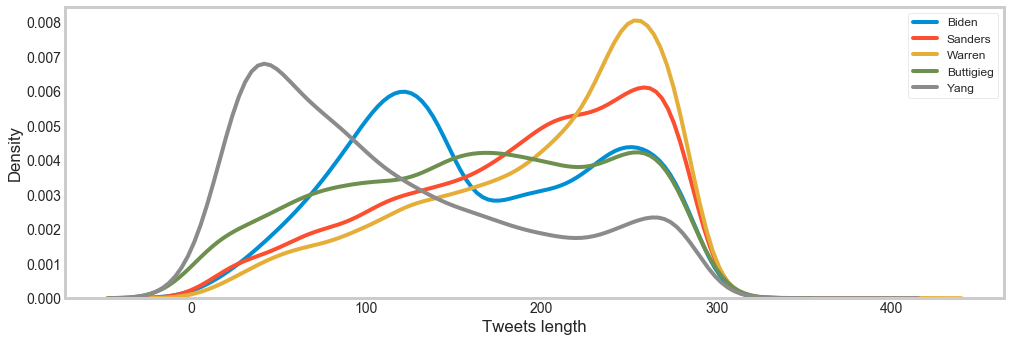

In [232]:
plt.figure(figsize=(15, 5))

df_hist = df[df.author == 'JoeBiden']
sns.distplot(df_hist['length'], hist = False, kde = True, label='Biden')

df_hist = df[df.author == 'BernieSanders']
sns.distplot(df_hist['length'], hist = False, kde = True, label='Sanders')

df_hist = df[df.author == 'ewarren']
sns.distplot(df_hist['length'], hist = False, kde = True, label='Warren')

df_hist = df[df.last_name == 'Buttigieg']
sns.distplot(df_hist['length'], hist = False, kde = True, label='Buttigieg')

df_hist = df[df.author == 'AndrewYang']
sns.distplot(df_hist['length'], hist = False, kde = True, label='Yang')

plt.xlabel('Tweets length')
plt.ylabel('Density')
plt.legend(prop={'size': 12})
plt.show()

Text(0, 0.5, 'Candidates')

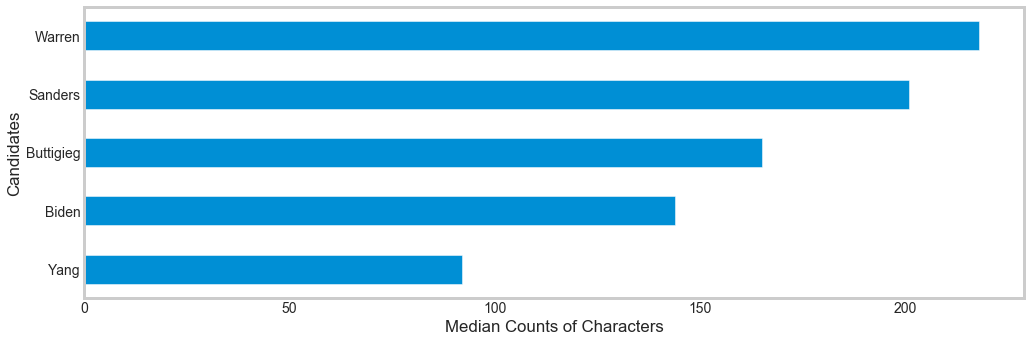

In [233]:
plt.figure(figsize=(15, 5))
df.groupby('last_name').length.median().sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Median Counts of Characters')
plt.ylabel('Candidates')

In [234]:
len(df[(df.last_name == 'Yang')&(df.length < 100)])

3062

In [235]:
len(df[(df.last_name == 'Yang')&(df.length < 100)])/len(df[df.last_name == 'Yang'])

0.5340076735263342

#### Usage of special characters, eg. emoji, hashtag and mentions.

Text(0.5, 1.0, 'How Five Democratic Candidates Use Emoji in Their Tweets')

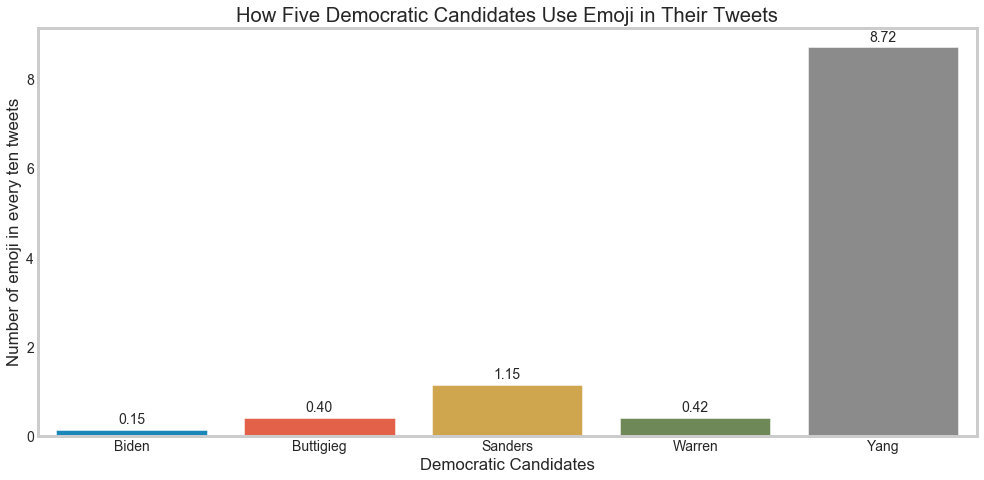

In [236]:
emoji_use = pd.DataFrame(df.groupby('last_name')['Emoji'].mean() * 10)

plt.figure(figsize = (15, 7))
emoji_plot = sns.barplot(x=emoji_use.index, y = emoji_use['Emoji'])
for p in emoji_plot.patches:
    emoji_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
plt.xlabel('Democratic Candidates')
plt.ylabel('Number of emoji in every ten tweets')
plt.title('How Five Democratic Candidates Use Emoji in Their Tweets')

Text(0.5, 1.0, 'How Five Democratic Candidates Use # in Their Tweets')

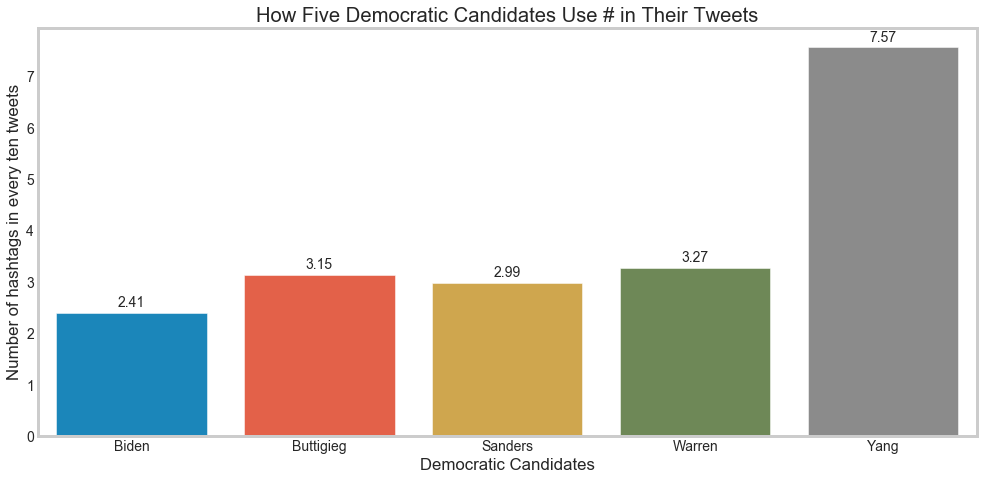

In [237]:
hash_use = pd.DataFrame(df.groupby('last_name')['Hashtag'].mean() *10)

plt.figure(figsize = (15, 7))
hash_plot = sns.barplot(x=hash_use.index, y = hash_use['Hashtag'])
for p in hash_plot.patches:
    hash_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
plt.xlabel('Democratic Candidates')
plt.ylabel('Number of hashtags in every ten tweets')
plt.title('How Five Democratic Candidates Use # in Their Tweets')

Text(0.5, 1.0, 'How Five Democratic Candidates Use @ in Their Tweets')

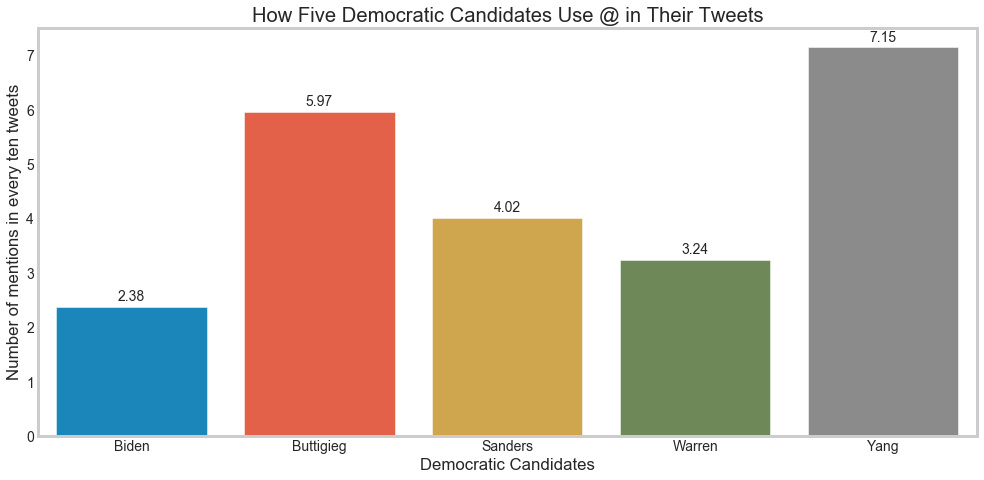

In [238]:
mention_use = pd.DataFrame(df.groupby('last_name')['Mention'].mean() *10)

plt.figure(figsize = (15, 7))
mention_plot = sns.barplot(x=mention_use.index, y = mention_use['Mention'])
for p in mention_plot.patches:
    mention_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
plt.xlabel('Democratic Candidates')
plt.ylabel('Number of mentions in every ten tweets')
plt.title('How Five Democratic Candidates Use @ in Their Tweets')

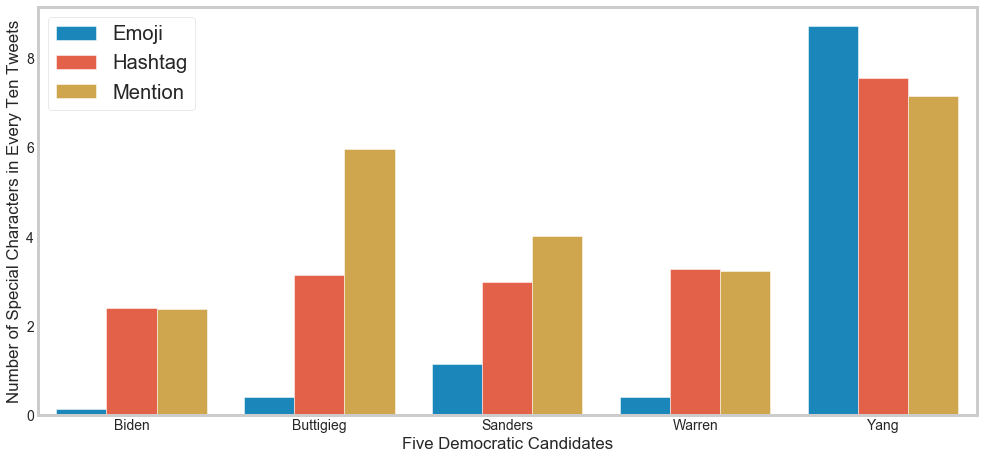

In [239]:
# Combine the above three charts into one
special_use = emoji_use.merge(hash_use, on = 'last_name').merge(mention_use, on = 'last_name')
special_use.reset_index(inplace=True)

# Reshape the df for visualization
special_use = pd.melt(special_use, id_vars=['last_name'], 
                      value_vars = ['Emoji', 'Hashtag', 'Mention'])

# Plot the bar chart
plt.figure(figsize = (15, 7))
sns.barplot(x='last_name', y = 'value', hue = 'variable', data = special_use)
plt.xlabel('Five Democratic Candidates')
plt.ylabel('Number of Special Characters in Every Ten Tweets')
plt.legend(loc='upper left', fontsize='x-large')

#### Compare number of likes and retweets each Candidate received

In [240]:
# Prepare the df for visualization
re_fav = pd.DataFrame(df.groupby('last_name')[['favorite_count', 'rewteet_count']].mean()).reset_index()
re_fav = re_fav.rename(columns={'favorite_count': 'Like', 'rewteet_count': 'Retweet'})
re_fav = pd.melt(re_fav, id_vars=['last_name'], value_vars = ['Like', 'Retweet'])
re_fav

,last_name,variable,value
0,Biden,Like,8390.112778
1,Buttigieg,Like,4288.874307
2,Sanders,Like,12701.744301
3,Warren,Like,7705.239230
4,Yang,Like,3295.471747
5,Biden,Retweet,1875.670556
6,Buttigieg,Retweet,1011.377079
7,Sanders,Retweet,2685.737611
8,Warren,Retweet,1499.909266
9,Yang,Retweet,675.881060


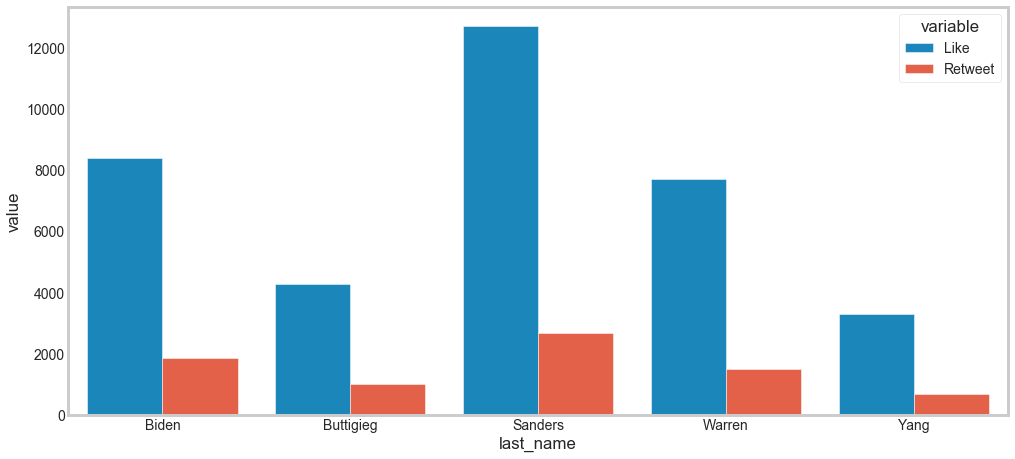

In [241]:
plt.figure(figsize = (15, 7))
sns.barplot(y = 'value', x = 'last_name', hue = 'variable', data = re_fav)

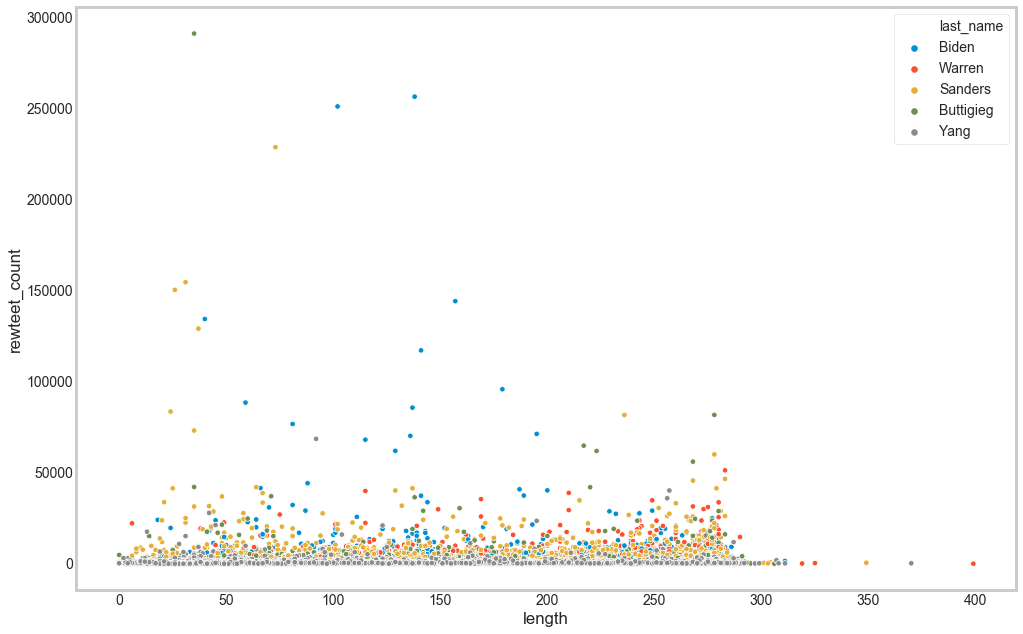

In [242]:
plt.figure(figsize = (15, 10))
sns.scatterplot(x = 'length', y = 'rewteet_count', hue = 'last_name', s = 30, data=df)
# plt.yscale('log')

#### Tweet Frequency

In [243]:
# Set the date of the tweet as index to make time series analysis

# Return the datetime column to string and save as a new column
df['tweet_time'] = df['created_at'].astype(str)
# Split the datetime string and save the first element as date, the second as time
df['tweet_date'] = [x[0] for x in df['tweet_time'].str.split(' ')]
df['tweet_date'] = pd.to_datetime(df['tweet_date'])
df['tweet_time'] = [x[1] for x in df['tweet_time'].str.split(' ')]

# Set the tweet_date as index and save as a new df
df_date = df.set_index('tweet_date')

# Drop the tweet_time column
df_date = df_date.drop('tweet_time', axis = 1)

In [244]:
# Joe Biden is not a regular Twitter user, and his first tweet in this database can date baclk to 2012.
# To make the data more relevant, narrow down tweets since 2019
df_date = df_date.sort_index(by = 'tweet_date')
tweets_2019 = df_date.loc['2019-10-01':'2020-02-01']

/Users/yangsun/anaconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  This is separate from the ipykernel package so we can avoid doing imports until


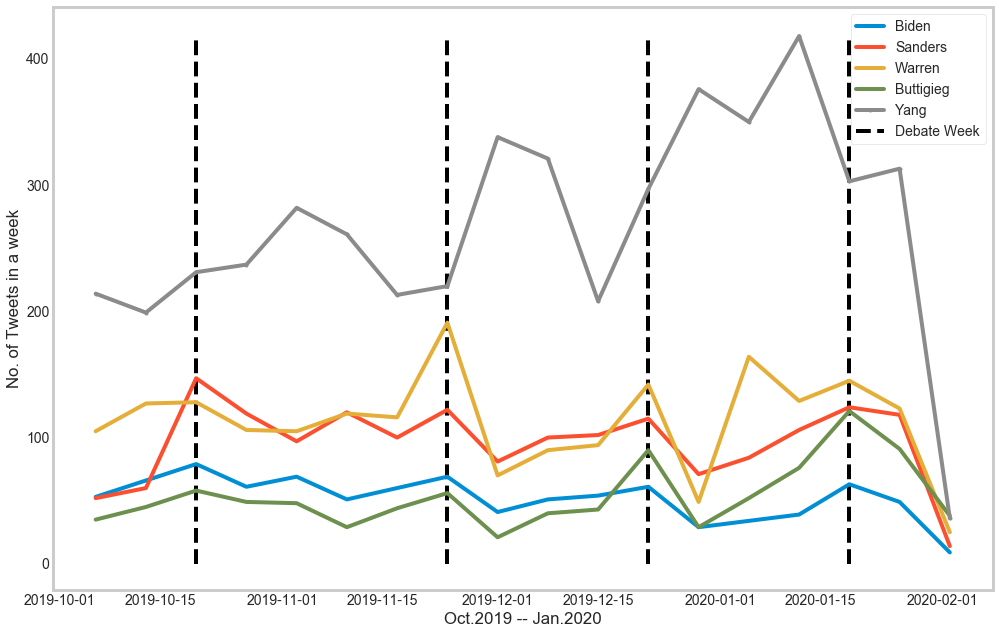

In [245]:
plt.figure(figsize=(15, 10))
_ = plt.plot(tweets_2019[tweets_2019.last_name == 'Biden'].resample('1w').tweet_id.count(), label = 'Biden')
_ = plt.plot(tweets_2019[tweets_2019.last_name == 'Sanders'].resample('1w').tweet_id.count(), label = 'Sanders')
_ = plt.plot(tweets_2019[tweets_2019.last_name == 'Warren'].resample('1w').tweet_id.count(), label = 'Warren')
_ = plt.plot(tweets_2019[tweets_2019.last_name == 'Buttigieg'].resample('1w').tweet_id.count(), label = 'Buttigieg')
_ = plt.plot(tweets_2019[tweets_2019.last_name == 'Yang'].resample('1w').tweet_id.count(), label = 'Yang', marker = '.')

_ = plt.vlines(x = '2019-10-20', ymin=0, ymax=420, linestyles='dashed', label = 'Debate Week')
_ = plt.vlines(x = '2019-11-24', ymin=0, ymax=420, linestyles='dashed')
_ = plt.vlines(x = '2019-12-22', ymin=0, ymax=420, linestyles='dashed')
_ = plt.vlines(x = '2020-01-19', ymin=0, ymax=420, linestyles='dashed')

plt.xlabel('Oct.2019 -- Jan.2020')
plt.ylabel('No. of Tweets in a week')
plt.legend()
plt.show()

In [246]:
# Export the preprocessed df for nlp analysis and modeling.
df.to_csv('df_nlp.csv')

In [247]:
tweets_2019[tweets_2019.last_name == 'Biden'].resample('1w').tweet_id.count()

tweet_date
2019-10-06    53
2019-10-13    66
2019-10-20    79
2019-10-27    61
2019-11-03    69
2019-11-10    51
2019-11-17    60
2019-11-24    69
2019-12-01    41
2019-12-08    51
2019-12-15    54
2019-12-22    61
2019-12-29    29
2020-01-05    34
2020-01-12    39
2020-01-19    63
2020-01-26    49
2020-02-02     9
Freq: W-SUN, Name: tweet_id, dtype: int64

In [248]:
df.groupby(['last_name', 'followers']).followers.count()

last_name  followers
Biden      3975760      1568
           3975761      1620
           3975831        40
           4137244       152
           4137245       220
Buttigieg  1561300        20
           1561311       260
           1561313       300
           1561314       180
           1561315       820
           1561316      1042
           1561317       599
           1601136       526
           1601141        40
Sanders    10045477       40
           10045555     1382
           10045556      360
           10045557     1120
           10045558      320
           10389510       20
           10389512       20
           10389590      100
           10389591      160
           10389592      280
           10389593      120
           10389594      114
Warren     3514770        80
           3514771       380
           3514772       580
           3514773      2000
           3514774       142
           3514840        40
           3656745       680
           3656746    

In [249]:
# biden rate (2019-12-3 to 2020-1-28)
(4137245 - 3975760) / 3975760

0.04061739139183452

In [250]:
# Buttigieg rate
(1601141 - 1561300) / 1561300

0.025517837699353105

In [251]:
# Sanders rate
(10389594 - 10045477) / 10045477

0.03425591437818234

In [252]:
# Warren rate
(3656754 - 3514770) / 3514770

0.04039638440068625

In [253]:
#Yang rate
(1208027 - 1052581) / 1052581

0.1476807960622508

In [254]:
increase_rate = {
    'Biden':{
        'December': 3975760,
        'January': 4137245
    },
    
    'Buttigieg': {
        'December': 1561300,
        'January': 1601141
    },
    
    'Sanders': {
        'December': 10045477,
        'January': 10389594
    },
    
    'Warren': {
        'December': 3514770,
        'January': 3656754
    },
    
    'Yang': {
        'December': 1052581,
        'January': 1208027
    }
}

In [264]:
gains = pd.DataFrame(increase_rate)

In [266]:
gains = gains.transpose()

In [268]:
gains['change%'] = (gains['January'] - gains['December'])/gains['December']

In [269]:
gains

,December,January,change%
Biden,3975760,4137245,0.040617
Buttigieg,1561300,1601141,0.025518
Sanders,10045477,10389594,0.034256
Warren,3514770,3656754,0.040396
Yang,1052581,1208027,0.147681


Text(0.5, 1.0, 'Followers Growth Dec.2019 - Jan.2020')

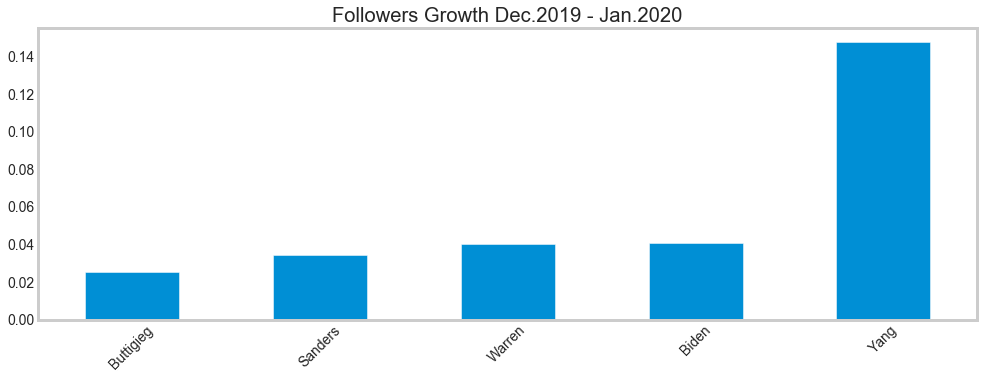

In [281]:
plt.figure(figsize=(15, 5))
gains['change%'].sort_values(ascending=True).plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Followers Growth Dec.2019 - Jan.2020')

In [256]:
len(tweets_2019[tweets_2019.last_name == 'Yang'])/len(tweets_2019[tweets_2019.last_name == 'Yang'].index.unique())

40.141666666666666

In [257]:
len(tweets_2019[tweets_2019.last_name == 'Yang'].index.unique())

120

In [258]:
len(tweets_2019[tweets_2019.last_name == 'Sanders'])/len(tweets_2019[tweets_2019.last_name == 'Sanders'].index.unique())

14.433333333333334

In [259]:
len(tweets_2019[tweets_2019.last_name == 'Biden'])/len(tweets_2019[tweets_2019.last_name == 'Biden'].index.unique())

7.816666666666666

In [260]:
len(tweets_2019[tweets_2019.last_name == 'Warren'])/len(tweets_2019[tweets_2019.last_name == 'Warren'].index.unique())

16.9

In [261]:
len(tweets_2019[tweets_2019.last_name == 'Buttigieg'])/len(tweets_2019[tweets_2019.last_name == 'Buttigieg'].index.unique())

8.109243697478991

In [263]:
df[df.last_name == 'Yang']['length'].max()

370